In [ ]:
using Pkg; Pkg.add("ControlSystemIdentification"); Pkg.add("Plots")

In this notebook, we will explore system identification by means of spectral methods using [ControlSystemIdentification.jl](https://github.com/baggepinnen/ControlSystemIdentification.jl)
Before any identification can begin, we need to load all the relevant packages.

In [1]:
using ControlSystemIdentification, ControlSystems, Plots
using Random, LinearAlgebra
default(size=(500,280))

We start by creating a system to use as the subject of identification and some data to use for identification

In [2]:
T          = 100000
h          = 1 # This is the sample time
sim(sys,u) = lsim(sys, u, 1:T)[1][:]
σy         = 0.5
sys        = tf(1,[1,2*0.1,0.1])
ωn         = sqrt(0.3)
sysn       = tf(σy*ωn,[1,2*0.1*ωn,ωn^2])

u  = randn(1, T)
y  = sim(sys, u)
yn = y + sim(sysn, randn(size(u)))
d = iddata(yn, u, h)

InputOutput data of length 100000 with 1 outputs and 1 inputs

Before we consider identification, we inspect the cross coherence function to determine whether or not a linear model is suitable for the data at hand. The cross coherence will be close to one if there is a linear relation between output and input. If the system is nonlinear, or subject to heavy noise, the cross coherence will drop.

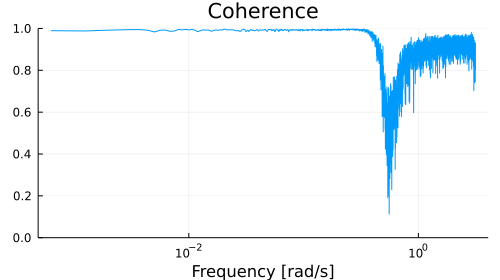

In [3]:
coherenceplot(d)

As indicated by the coherence function, a linear model will be able to describe this data well, except for around $\sqrt{0.3}=0.55$ rad/s (which happens to be the resonance frequncy of the noise we added ;)

We are now confident that we can proceede with a linear model, but will have to be weary of trusting it around 0.55 rad/s. The main entrypoint to transfer-function estimation using spectral methods is `tfest`

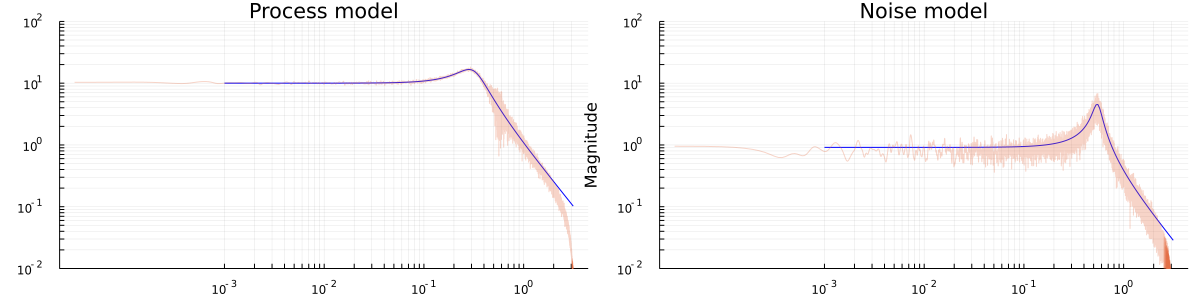

In [4]:
G,N = tfest(d)
bodeplot([sys,sysn], exp10.(range(-3, stop=log10(pi), length=200)), layout=(1,2), plotphase=false, subplot=1:2, size=(2*600, 300), ylims=(0.01,100), linecolor=:blue)
plot!(G, subplot=1, lab="G Est", alpha=0.3, title="Process model")
plot!(√N, subplot=2, lab="N Est", alpha=0.3, title="Noise model")

The returned objects are of type `FRD` (frequency-response data) and can be plotted. `G` is the estimated transfer function of the model, whereas `N` is an estimate of the power-spectral density of the noise. We plotted them together with the true functions to compare. We clearly see the increase variance in the estimate of the process model around the resonance frequency of the measurement noise, thankfully, we already knew to trust our model less here since we inspected the coherence function.

Spectral methods for transfer-function estimation does not return a rational transfer function which we are used to, they are thus more difficult to use for prediction and simulation. They do however give a quick overview of the system at hand, and can indicate the number of poles/zeros in the system. They will never suffer from convergence issues and are very fast to compute, so why not have a look at them before attemting to estimate a parameteric model? :)